In [2]:
import os
import shutil

def organize_braTS_data(src_root="./data", dst_root="./dataset"):
    """
    Extract ./data to data and label form
    """
    os.makedirs(os.path.join(dst_root, "data"), exist_ok=True)
    os.makedirs(os.path.join(dst_root, "label"), exist_ok=True)
    case_number = 0
    for folder in sorted(os.listdir(src_root)):
        folder_path = os.path.join(src_root, folder)
        if os.path.isdir(folder_path):
            case_number += 1
            
            for file in os.listdir(folder_path):
                src_file = os.path.join(folder_path, file)
                if file.endswith("MRA.nii.gz"):
                    dst_file = os.path.join(dst_root, "data", f"data_{str(case_number)}.nii.gz")
                    shutil.move(src_file, dst_file)
                elif file.endswith("BinaryLabel.nii.gz"):
                    dst_file = os.path.join(dst_root, "label", f"label_{case_number}.nii.gz")
                    shutil.move(src_file, dst_file)

if __name__ == "__main__":
    organize_braTS_data()

In [3]:
import os
import nibabel as nib
import numpy as np
from scipy import ndimage
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

In [4]:
DEVICE = None
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Using CUDA!")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU!")
EPOCHS = 25
TRAIN_SPLIT = 0.8
LR = 1e-2
STEP_SIZE = 5
GAMMA = 0.1
MANUAL_SEED = 42
BATCH_SIZE = 2
CLASS = 5
TARGET_SIZE = 128

Using CUDA!


In [5]:
import torch
import numpy as np
import random

def set_random_seed(seed):
    """
    모든 관련 라이브러리의 랜덤 시드를 고정합니다.
    
    Args:
        seed (int): 고정할 랜덤 시드 값
    """
    # Python 내장 랜덤 시드 고정
    random.seed(seed)
    
    # NumPy 랜덤 시드 고정
    np.random.seed(seed)
    
    # PyTorch 랜덤 시드 고정
    torch.manual_seed(seed)  # CPU에서 PyTorch 랜덤 시드 고정
    torch.cuda.manual_seed(seed)  # GPU에서 PyTorch 랜덤 시드 고정 (CUDA 장치)
    torch.cuda.manual_seed_all(seed)  # 모든 GPU에서 PyTorch 랜덤 시드 고정
    
    # CuDNN 관련 설정
    torch.backends.cudnn.deterministic = True  # 결정적 알고리즘을 사용하여 결과 고정
    torch.backends.cudnn.benchmark = False  # 벤치마크 모드를 비활성화하여 성능 최적화 방지

# 시드 고정 예시
set_random_seed(MANUAL_SEED)

In [6]:
def read_nifti_file(filepath):
    """Read and load volume"""
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min_val = -1000
    max_val = 400
    volume[volume < min_val] = min_val
    volume[volume > max_val] = max_val
    volume = (volume - min_val) / (max_val - min_val)
    volume = volume.astype("float32")
    return volume

# interpolation?
def resize(image, target_size):
    """이미지 크기 조정 (PIL 없이 numpy 기반)"""
    print(image.ndim)
    # 이미지가 2D일 경우 (H, W)로 크기 조정
    if image.ndim == 2:
        return scipy.ndimage.zoom(image, (target_size[0] / image.shape[0], target_size[1] / image.shape[1]), order=1)
    # 이미지가 3D일 경우 (H, W, C)로 크기 조정
    elif image.ndim == 3:
        return np.concatenate([scipy.ndimage.zoom(image[..., i], (target_size[0] / image.shape[0], target_size[1] / image.shape[1]), order=1)[:, :, np.newaxis] for i in range(image.shape[2])], axis=-1)
    else:
        raise ValueError("Unsupported image dimensions")
            
def resize_volume(img):
    """Resize to 64x64x64"""
    desired_depth = TARGET_SIZE
    desired_width = TARGET_SIZE
    desired_height = TARGET_SIZE
    
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    depth_factor = desired_depth / current_depth
    width_factor = desired_width / current_width
    height_factor = desired_height / current_height
    
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [7]:
import os

# 경로 설정 (현재 작업 디렉토리 기준)
data_dir = './dataset/label'

# 숫자 001부터 369까지 파일이 있는지 확인 (_001, _002, ...)
expected_files = [f"label_{str(i)}.nii" for i in range(1, 25)]
print(expected_files)
# 실제 파일 목록 가져오기
try:
    actual_files = sorted(os.listdir(data_dir))
    # 실제 파일 목록에 있는지 확인
    missing_files = [file for file in expected_files if file not in actual_files]

    if missing_files:
        print("Missing files:", missing_files)
    else:
        print("All expected files are present.")
except FileNotFoundError:
    print(f"The directory {data_dir} does not exist.")


['label_1.nii', 'label_2.nii', 'label_3.nii', 'label_4.nii', 'label_5.nii', 'label_6.nii', 'label_7.nii', 'label_8.nii', 'label_9.nii', 'label_10.nii', 'label_11.nii', 'label_12.nii', 'label_13.nii', 'label_14.nii', 'label_15.nii', 'label_16.nii', 'label_17.nii', 'label_18.nii', 'label_19.nii', 'label_20.nii', 'label_21.nii', 'label_22.nii', 'label_23.nii', 'label_24.nii']
Missing files: ['label_1.nii', 'label_2.nii', 'label_3.nii', 'label_4.nii', 'label_5.nii', 'label_6.nii', 'label_7.nii', 'label_8.nii', 'label_9.nii', 'label_10.nii', 'label_11.nii', 'label_12.nii', 'label_13.nii', 'label_14.nii', 'label_15.nii', 'label_16.nii', 'label_17.nii', 'label_18.nii', 'label_19.nii', 'label_20.nii', 'label_21.nii', 'label_22.nii', 'label_23.nii', 'label_24.nii']


In [8]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

class MRADataset(Dataset):
    def __init__(self, data_dir, label_dir):
        self.data_paths = sorted([f for f in os.listdir(data_dir) if f.endswith('.nii.gz')])
        self.label_paths = sorted([f for f in os.listdir(label_dir) if f.endswith('.nii.gz')])
        self.data_dir = data_dir
        self.label_dir = label_dir
        
        # 데이터와 라벨의 개수가 일치하는지 확인
        assert len(self.data_paths) == len(self.label_paths), \
            f"Mismatch between data and label files: {len(self.data_paths)} | {len(self.label_paths)}"
    
    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, idx):
        data_path = os.path.join(self.data_dir, self.data_paths[idx])
        label_path = os.path.join(self.label_dir, self.label_paths[idx])
        
        data = read_nifti_file(data_path)
        label = read_nifti_file(label_path)

        data = normalize(data)
        data = resize_volume(data)
        label = resize_volume(label)

        # Convert numpy to torch tensor
        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)     # Add channel dimension
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)   # For segmentation tasks, long type is needed for one-hot encoding
        label = torch.where(label != 0, torch.tensor(1, dtype=torch.float32, device=label.device), torch.tensor(0, dtype=torch.float32, device=label.device))

        return data, label


In [10]:
dataset = MRADataset("./dataset/data", "./dataset/label")
train_size = int(0.8 * len(dataset))
print(train_size)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

19


data shape:  torch.Size([1, 128, 128, 128]) <class 'torch.Tensor'>
label shape:  torch.Size([1, 128, 128, 128]) <class 'torch.Tensor'>
(128, 128, 128)
(128, 128, 128)


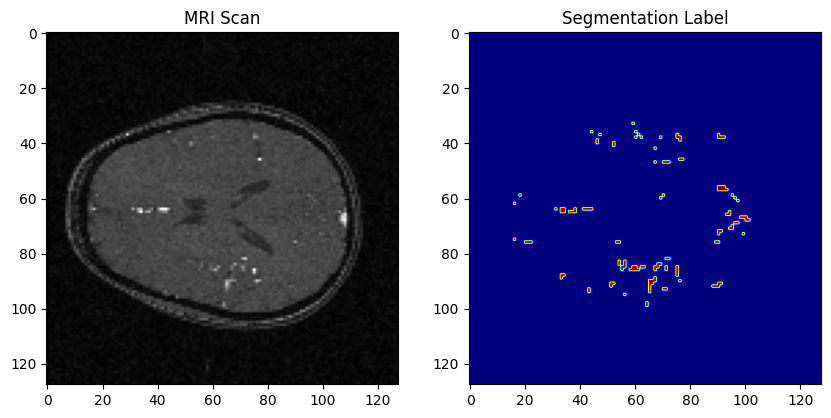

In [11]:
def visualize_sample(dataset, idx=0):
    """Visualize a single sample from the dataset"""
    data, label = dataset[idx]
    print("data shape: ", data.shape, type(data))
    print("label shape: ", label.shape, type(label))
    
    data = data.squeeze().numpy()
    label = label.squeeze().numpy()
    
    print(data.shape)
    print(label.shape)
    slice_idx = data.shape[-1] // 2  # Select middle slice
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data[:, :, slice_idx], cmap='gray')
    axes[0].set_title("MRI Scan")
    
    axes[1].imshow(label[:, :, slice_idx], cmap='jet')
    axes[1].set_title("Segmentation Label")
    
    plt.show()

visualize_sample(dataset, idx=0)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv3D -> BatchNorm -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, features=[32, 64, 128, 256, 512]):
        super(UNet3D, self).__init__()
        
        # stack contracting path
        self.encoder = nn.ModuleList()
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        
        self.upconv = nn.ModuleList()
        self.decoder = nn.ModuleList()
        for feature in reversed(features):
            self.upconv.append(nn.ConvTranspose3d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(DoubleConv(feature * 2, feature))
        
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)
        # init weight
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
                nn.init.xavier_uniform_(m.weight)  # Xavier init for weights
                if m.bias is not None:
                    nn.init.zeros_(m.bias)  # Bias to zero
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.ones_(m.weight)  # Scale gamma to 1
                nn.init.zeros_(m.bias)  # Shift beta to 0

    def forward(self, x):
        # save skip connections
        skip_connections = []
        for enc in self.encoder:
            x = enc(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]
        for idx in range(len(self.upconv)):
            x = self.upconv[idx](x)
            x = torch.cat((x, skip_connections[idx]), dim=1)
            x = self.decoder[idx](x)
        
        return self.final_conv(x)

In [35]:
model = UNet3D(in_channels=1, out_channels=1)
x = torch.randn(1, 1, 64, 64, 64)  # Example 3D volume
output = model(x)
print(output.shape)

torch.Size([1, 1, 64, 64, 64])


In [36]:
model.to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)  # Reduce LR by 0.1 every 5 epochs

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for data, label in progress_bar:
        # extract data and label
        data, label = data.to(DEVICE), label.to(DEVICE)

        # reset optimizer
        optimizer.zero_grad()

        # model output
        output = model(data)

        loss = criterion(output, label)
        loss.backward()
    
        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())
    
    # save model
    torch.save(model.state_dict(), f'./model/3DUNet_{epoch+1}.pth')
    print(f"Epoch {epoch+1} Loss: {epoch_loss/len(train_loader):.4f}")

    # learning rate scheduler step
    scheduler.step()

Epoch 1/25:   0%|          | 0/10 [00:02<?, ?it/s]


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import nibabel as nib
from tqdm import tqdm

def save_as_nifti(tensor, filename):
    """ Save a tensor as a NIfTI file. """
    nifti_img = nib.Nifti1Image(tensor, affine=np.eye(4))  # 단위 행렬 사용
    nib.save(nifti_img, filename)

def multiclass_dice_coeff(input, target, epsilon=1e-6):
    """
    Compute Dice Score for multi-class segmentation.
    
    Args:
        input (torch.Tensor): Model output logits (D, H, W).
        target (torch.Tensor): Ground truth labels (D, H, W).
        epsilon (float): Small value to avoid division by zero.
        
    Returns:
        mean_dice (float): Mean Dice Score across all classes.
    """
    print(input.shape)
    print(target.shape)
    intersection = (input * target).sum()
    union = input.sum() + target.sum()
    
    dice_per_class = (2. * intersection + epsilon) / (union + epsilon)
    mean_dice = dice_per_class.mean()  # 전체 클래스 평균 Dice Score

    return mean_dice

# ============== Test Loop ==============
save = False
batch_dice_scores = []

model.to(DEVICE)
model.eval()
total_loss = 0
criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for batch_idx, (data, label) in tqdm(enumerate(test_loader), desc="Testing"):
        data, label = data.to(DEVICE), label.to(DEVICE)

        # 모델 예측
        output = model(data)  # Output: (batch, C, D, H, W)
        unique_values = torch.unique(output)
        
        print("Tensor의 유일한 값:", unique_values)
        # 손실 계산
        loss = criterion(output, label)
        output = torch.sigmoid(output)  # 시그모이드 적용
        output = (output >= 0.5).float()  # Threshold 적용 (0.5 이상이면 1, 아니면 0)

        total_loss += loss.item()

        # Dice Score 계산
        batch_dice = []
        for i in range(data.size(0)):  # 배치 내 개별 샘플 처리
            input = output[i].squeeze().cpu().numpy()
            target = label[i].squeeze().cpu().numpy()
            dice = multiclass_dice_coeff(input, target)  
            batch_dice.append(dice.item())

        batch_dice_scores.extend(batch_dice)  # 전체 결과 리스트에 추가

        # 저장 (1회만 실행)
        if not save:
            pred = output[0].squeeze().cpu().numpy()
            gt_label = label[0].squeeze().cpu().numpy()

            save_as_nifti(pred.astype(np.int16), f"pred_{batch_idx}.nii")
            save_as_nifti(gt_label.astype(np.int16), f"label_{batch_idx}.nii")
            save = True

# 최종 평균 Dice Score 및 Loss 계산
avg_dice = np.mean(batch_dice_scores)
avg_loss = total_loss / len(test_loader)

print(f"Test Dice Accuracy: {avg_dice:.4f}")
print(f"Average Test Loss: {avg_loss:.4f}")

Testing: 1it [00:01,  1.57s/it]

Tensor의 유일한 값: tensor([-7.2860, -7.2436, -7.2390,  ..., -1.0212, -1.0204, -1.0079],
       device='cuda:0')
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


Testing: 2it [00:02,  1.47s/it]

Tensor의 유일한 값: tensor([-7.2680, -7.2455, -7.2361,  ..., -0.9051, -0.9008, -0.8988],
       device='cuda:0')
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


Testing: 3it [00:03,  1.22s/it]

Tensor의 유일한 값: tensor([-7.2425, -7.2377, -7.1700,  ..., -1.0722, -0.9745, -0.9398],
       device='cuda:0')
(64, 64, 64)
(64, 64, 64)
Test Dice Accuracy: 0.0000
Average Test Loss: 0.0352
